In [3]:
%matplotlib inline

import matplotlib.pyplot as plt
from matplotlib.colors import LinearSegmentedColormap
from mpl_toolkits.axes_grid1 import make_axes_locatable
import math
import numpy as np
import pandas as pd
import xarray as xr
import seaborn as sns
import scipy.stats as stat
from sklearn.preprocessing import QuantileTransformer
from sklearn.preprocessing import quantile_transform

print("pandas version : ", pd.__version__)
print("xarray version : ", xr.__version__)

sns.set_style("whitegrid")
plt.rcParams["font.family"] = 'sans-serif'

('pandas version : ', u'0.23.4')
('xarray version : ', u'0.11.0')


### Test residual generation method by Montanari and Brath 2004
https://agupubs.onlinelibrary.wiley.com/doi/full/10.1029/2003WR002540

note:
vic streamflow is mm/day
mhm streamflow is m3/sec

In [4]:
# Getting Data: 
# 1. simulated streamflow from vic and mhm
# 2. Basin list file

data_path = './data'

# List of objective functions used
obj_fun_list = ['nse','kge']
# List of models used
model_list = ['vic', 'mhm']

# Read model deterministic simulated streamflow at daily steps
ds_vic_flow_all = xr.open_dataset('%s/results_hcdn_flow_vic_491.nc'%data_path)
ds_mhm_flow_all = xr.open_dataset('%s/results_hcdn_flow_mhm_491.nc'%data_path)

# Read basin attributes 
df_hcdn = pd.read_csv('%s/hcdn.calib.conus.491.list'%data_path, delim_whitespace=True,
                   header=None, names=['id', 'lat', 'lon', 'area'])    #area is sq-meters

hcdn = df_hcdn['id']
nbasin = len(df_hcdn['id'])
ndata = len(obj_fun_list)
nmodel = len(model_list)

# Print data variables
print('VIC flow data')
print('-------------')
print(ds_vic_flow_all)
print('\nmHM flow data')
print('-------------')
print(ds_mhm_flow_all)

VIC flow data
-------------
<xarray.Dataset>
Dimensions:      (hcdn: 491, time: 6940)
Coordinates:
  * hcdn         (hcdn) int64 1022500 1031500 1047000 ... 14362250 14400000
  * time         (time) datetime64[ns] 1989-10-01 1989-10-02 ... 2008-09-30
Data variables:
    nse          (hcdn, time) float32 ...
    kge          (hcdn, time) float32 ...
    kge_alpha    (hcdn, time) float32 ...
    kge_2alpha   (hcdn, time) float32 ...
    kge_5alpha   (hcdn, time) float32 ...
    kge_10alpha  (hcdn, time) float32 ...
    sig1         (hcdn, time) float32 ...
    obs          (hcdn, time) float32 ...

mHM flow data
-------------
<xarray.Dataset>
Dimensions:     (hcdn: 491, time: 6940)
Coordinates:
  * hcdn        (hcdn) int64 1022500 1031500 1047000 ... 14362250 14400000
  * time        (time) datetime64[ns] 1989-10-01 1989-10-02 ... 2008-09-30
Data variables:
    nse         (hcdn, time) float32 ...
    kge_2alpha  (hcdn, time) float32 ...
    kge         (hcdn, time) float32 ...
    sig1 

In [5]:
# Calibration period
ds_vic_flow_cal = ds_vic_flow_all.sel(time=slice('1999-10-01', '2008-09-30'))
ds_mhm_flow_cal = ds_mhm_flow_all.sel(time=slice('1999-10-01', '2008-09-30'))
ntime_cal = len(ds_vic_flow_cal['time'])

prob_cal=np.arange(1,float(ntime_cal+1))/(1+ntime_cal) #probability
for d in range(len(prob_cal)):
    idx50=d
    if prob_cal[d] > 0.5: break
for d in range(len(prob_cal)):
    idx30=d
    if prob_cal[d] > 0.3: break
for d in range(len(prob_cal)):
    idx80=d
    if prob_cal[d] > 0.8: break

In [6]:
# validation period
ds_vic_flow_val = ds_vic_flow_all.sel(time=slice('1989-10-01', '1999-09-30'))
ds_mhm_flow_val = ds_mhm_flow_all.sel(time=slice('1989-10-01', '1999-09-30'))
ntime_val = len(ds_vic_flow_val['time'])

prob_val=np.arange(1,float(ntime_val+1))/(1+ntime_val) #probability
for d in range(len(prob_val)):
    idx50=d
    if prob_val[d] > 0.5: break
for d in range(len(prob_val)):
    idx30=d
    if prob_val[d] > 0.3: break
for d in range(len(prob_val)):
    idx80=d
    if prob_val[d] > 0.8: break

In [7]:
# Personal functions used here.
def nse(qsim, qobs):
    return 1-np.sum((qsim-qobs)**2)/np.sum((qobs-np.mean(qobs))**2)

def corr(qsim, qobs):
    return np.corrcoef(qsim, qobs)[0, 1]
    
def alpha(qsim, qobs):
    return math.sqrt(np.sum((qsim-np.mean(qsim))**2)/len(qsim))/math.sqrt(np.sum((qobs-np.mean(qobs))**2)/len(qobs))
    
def beta(qsim, qobs):
    return np.mean(qsim)/np.mean(qobs)

def kge(qsim, qobs):
    return 1-math.sqrt((1-corr(qsim, qobs))**2 + (alpha(qsim, qobs)-1)**2 + (beta(qsim, qobs)-1)**2)

def pbias(qsim, qobs):
    return np.sum((qsim-qobs))/np.sum(qobs)

In [99]:
def MB2004(sim, obs, nens):
    # sim:  1 dimension numpy array
    # obs:  1 dimension numpy array
    
    vst = True
    
    nqt = QuantileTransformer(output_distribution='normal')
    
    sim = np.where(sim>0.0, sim, 1.0e-7)
    obs = np.where(obs>0.0, obs, 1.0e-7)
    err = obs-sim
    
    sim_nqt = nqt.fit(sim).transform(sim)
    
    if vst:
        err_star = abs(err - np.mean(err))
        err_star_nqt = nqt.fit(err_star).transform(err_star)
        slope, intercept, _, _, _ = stat.linregress(sim_nqt.reshape(1, -1), err_star_nqt.reshape(1, -1))
        fs = nqt.fit(err_star).inverse_transform(slope*sim_nqt + intercept)
        err_vst = (err - np.mean(err))/fs
        err_nqt = nqt.fit(err_vst).transform(err_vst)
    else: 
        err_nqt = nqt.fit(err).transform(err)
    
    ro = corr(err_nqt.reshape(1, -1), sim_nqt.reshape(1, -1))
    myu = ro*sim_nqt # mean value normalized space
    sig2 = 1-ro**2    # variance of normalized space

    Ne_sampled = np.full((len(myu),nens),-999.)
    err_sampled = np.full((len(myu),nens),-999.)
    sim_sampled = np.full((len(myu),nens),-999.)
    for idx, m in enumerate(myu):
        Ne_sampled[idx,:] = np.random.normal(m, np.sqrt(sig2), (1, nens))
    
    for iens in range(nens):
        err_sampled[:,iens] = nqt.fit(err).inverse_transform(Ne_sampled[:,iens].reshape(-1, 1)).reshape(1, -1)
        sim_sampled[:,iens] = sim.reshape(1, -1)+err_sampled[:,iens].reshape(1, -1)
    return sim_sampled, err_sampled

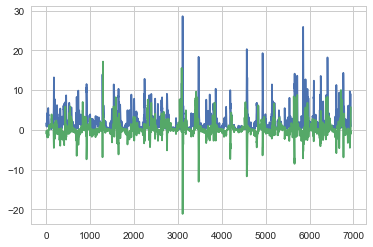

In [111]:
# test
hcdn = 1022500
sim=ds_vic_flow_all['kge'].sel(hcdn=hcdn)[0:].values
obs=ds_vic_flow_all['obs'].sel(hcdn=hcdn)[0:].values
sim = sim.reshape(-1, 1)
obs = obs.reshape(-1, 1)
sim = np.where(sim>0.0, sim, 1.0e-7)
obs = np.where(obs>0.0, obs, 1.0e-7)
err = obs-sim

nqt = QuantileTransformer(output_distribution='normal')

sim_nqt = nqt.fit(sim).transform(sim)
err_nqt = nqt.fit(err).transform(err)

plt.plot(sim, '-')
plt.plot(err, '-')
#ro = corr(err_nqt.reshape(1, -1), sim_nqt.reshape(1, -1))
#err1 = inverse_transform(err_nqt)
#err2 = enqt.inverse_transform(sim_nqt)
#plt.plot(err1,err1)

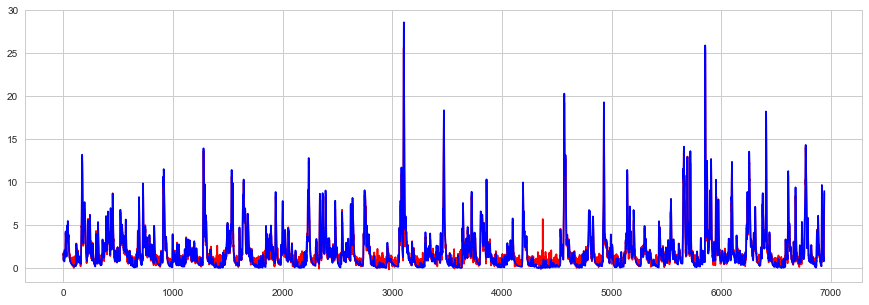

In [123]:
# test
sim=ds_vic_flow_all['kge'].sel(hcdn=hcdn)[0:].values
obs=ds_vic_flow_all['obs'].sel(hcdn=hcdn)[0:].values
sim = sim.reshape(-1, 1)
obs = obs.reshape(-1, 1)
sim_sampled, err_sampled = MB2004(sim, obs, 10)

sim_med = np.median(sim_sampled,axis=1)

_, ax = plt.subplots(figsize=(15, 5))
#ax.plot(sim_sampled[0:,:],'-',color='gray')
ax.plot(sim_med[0:],'-',color='red')
ax.plot(sim[0:],'-',color='blue')
#ax.plot(obs[0:],'-')

#ax.plot(ds_vic_flow_all['time'][1080:1380],q1[1080:1380,:], color='gray')
#ds_vic_flow_all['kge'].sel(hcdn=hcdn)[1080:1380].plot(ax = ax, color='blue')
#ds_vic_flow_all['obs'].sel(hcdn=hcdn)[1080:1380].plot(ax = ax, color='black')
#ax.set_ylim(0, 10)

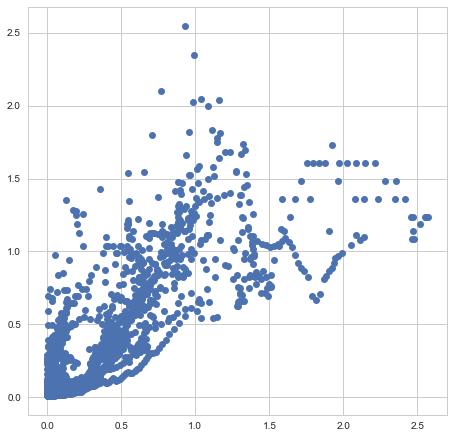

In [104]:
#plot scatter plots between obs and sim
_, ax = plt.subplots(figsize=(7.5, 7.5))
ax.plot(ds_vic_flow_all['kge'].sel(hcdn=hcdn)[0:365*10],ds_vic_flow_all['obs'].sel(hcdn=hcdn)[0:365*10], 'o')

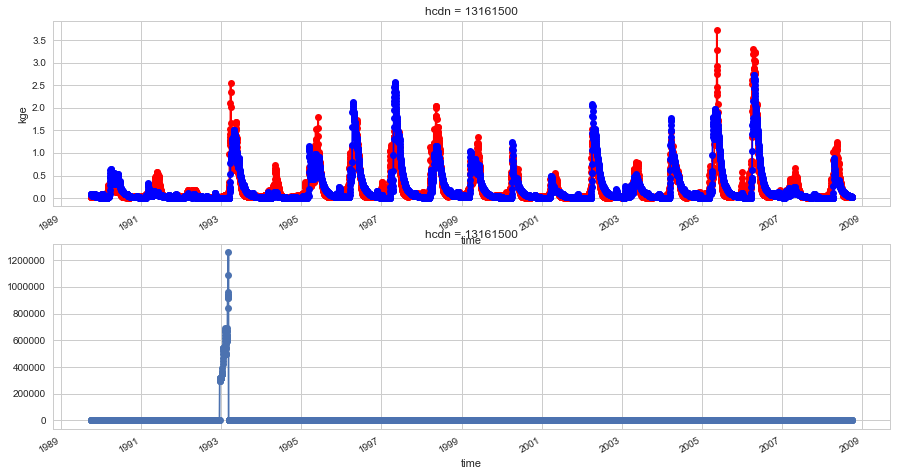

In [39]:
obs = ds_vic_flow_all['obs']
sim = ds_vic_flow_all['kge']
sim1 = sim.where(sim>0.0, 1.0e-7)
obs1 = obs.where(obs>0.0, 1.0e-7)
res = obs1/sim1
_, ax1 = plt.subplots(2,1, figsize=(15, 7.5))
obs.sel(hcdn=hcdn)[0:].plot(ax=ax1[0], marker='o', color='red')
sim.sel(hcdn=hcdn)[0:].plot(ax=ax1[0], marker='o', color='blue')
res.sel(hcdn=hcdn)[0:].plot(ax=ax1[1], marker='o')
#ax1[1].set_ylim(0, 2)